In [1]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/original_data.csv')
original_data_df.drop(['location'], axis = 1, inplace = True)
original_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max
0,19,54,1,18,1.4,-2.2,4.8
1,19,54,1,19,1.5,-1.3,5.8
2,19,54,1,20,4.7,-1.5,10.7
3,19,54,1,21,2.8,0.5,5.5
4,19,54,1,22,-2.1,-6.4,1.6


In [3]:
'''
결측치 확인
'''
original_data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     1
temp_max     2
dtype: int64

In [4]:
'''
결측치 바로 뒤에 있는 값으로 치환
'''
original_data_df.fillna(method = 'ffill', inplace = True)
original_data_df.isnull().sum()

frontyear    0
backyear     0
month        0
day          0
temp_avg     0
temp_min     0
temp_max     0
dtype: int64

In [5]:
'''
데이터프레임 데이터타입 변환
'''
original_data_df = original_data_df.apply(pd.to_numeric)

In [6]:
'''
계절성 데이터 추가

봄 : 3월 ~ 5월 - 0.05
여름 : 6월 ~ 8월 - 0.25
가을 : 9월 ~ 11월 - 0.42
겨울 : 12월 ~ 2월 - 0.28
'''
season_data = pd.DataFrame(original_data_df['month'])
season_data.columns = ['season']
original_data_df = pd.concat([original_data_df, season_data], axis = 1)
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frontyear  24336 non-null  int64  
 1   backyear   24336 non-null  int64  
 2   month      24336 non-null  int64  
 3   day        24336 non-null  int64  
 4   temp_avg   24336 non-null  float64
 5   temp_min   24336 non-null  float64
 6   temp_max   24336 non-null  float64
 7   season     24336 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.5 MB


In [7]:
'''
계절성 데이터 군집화
'''
for season in original_data_df:
    original_data_df.loc[(original_data_df['season'] >= 1) & (original_data_df['season'] < 3), 'season'] = 0.05
    original_data_df.loc[(original_data_df['season'] >= 3) & (original_data_df['season'] < 6), 'season'] = 0.25
    original_data_df.loc[(original_data_df['season'] >= 6) & (original_data_df['season'] < 9), 'season'] = 0.42
    original_data_df.loc[(original_data_df['season'] >= 9) & (original_data_df['season'] < 12), 'season'] = 0.28
    original_data_df.loc[(original_data_df['season'] >= 12), 'season'] = 0.05

In [8]:
'''
데이터프레임 확인
'''
original_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,19,54,1,18,1.4,-2.2,4.8,0.05
1,19,54,1,19,1.5,-1.3,5.8,0.05
2,19,54,1,20,4.7,-1.5,10.7,0.05
3,19,54,1,21,2.8,0.5,5.5,0.05
4,19,54,1,22,-2.1,-6.4,1.6,0.05


In [9]:
'''
데이터 스케일링
'''
max_abs_scaler = MaxAbsScaler()

scaled_data_np = max_abs_scaler.fit_transform(original_data_df)
scaled_data_df = pd.DataFrame(scaled_data_np)
scaled_data_df.columns = ['frontyear', 'backyear', 'month', 'day', 'temp_avg', 'temp_min', 'temp_max', 'season']
scaled_data_df.head()

,frontyear,backyear,month,day,temp_avg,temp_min,temp_max,season
0,0.95,0.545455,0.083333,0.580645,0.041543,-0.072607,0.121212,0.119048
1,0.95,0.545455,0.083333,0.612903,0.044510,-0.042904,0.146465,0.119048
2,0.95,0.545455,0.083333,0.645161,0.139466,-0.049505,0.270202,0.119048
3,0.95,0.545455,0.083333,0.677419,0.083086,0.016502,0.138889,0.119048
4,0.95,0.545455,0.083333,0.709677,-0.062315,-0.211221,0.040404,0.119048


In [10]:
'''
train, test 데이터 분리
'''
train_size = int(len(scaled_data_df) * 0.7)
train_data_df = scaled_data_df[0:train_size].reset_index(drop = True)
validation_data_df = scaled_data_df[:int(len(scaled_data_df) * 0.15):].reset_index(drop = True)
test_data_df = scaled_data_df[-int(len(scaled_data_df) * 0.15):].reset_index(drop = True)

In [11]:
'''
데이터 형태 확인
'''
print("train size:", train_size)
print("result df shape:", scaled_data_df.shape)
print("train df shape:", train_data_df.shape)
print("validation df shape:", validation_data_df.shape)
print("test df shape:", test_data_df.shape)

train size: 17035
result df shape: (24336, 8)
train df shape: (17035, 8)
validation df shape: (3650, 8)
test df shape: (3650, 8)


In [12]:
'''
input, label 데이터 분리
'''
x_train_data_df = train_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_train_data_df = train_data_df[['temp_avg', 'temp_min', 'temp_max']]

x_validation_data_df = validation_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_validation_data_df = validation_data_df[['temp_avg', 'temp_min', 'temp_max']]

x_test_data_df = test_data_df[['frontyear', 'backyear', 'month', 'day', 'season']]
y_test_data_df = test_data_df[['temp_avg', 'temp_min', 'temp_max']]

In [13]:
'''
데이터 형태 확인
'''
print("x train shape:", x_train_data_df.shape)
print("y train shape:", y_train_data_df.shape)
print("x validation shape:", x_validation_data_df.shape)
print("y validation shape:", y_validation_data_df.shape)
print("x test shape", x_test_data_df.shape)
print("y test shape", y_test_data_df.shape)

x train shape: (17035, 5)
y train shape: (17035, 3)
x validation shape: (3650, 5)
y validation shape: (3650, 3)
x test shape (3650, 5)
y test shape (3650, 3)


In [14]:
'''
GPU 사용
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [16]:
'''
하이퍼파라미터

입력 형태: (Batch Size, Sequence Length, Input Dimension)
'''
batch_size = 256 # 64년치 데이터
sequence_length = 1 # 한 개의 batch 당 몇 개의 sequence가 들어있는 개수
input_size = 5
hidden_size = 32
num_layers = 3
output_size = 3 # Trend, Seasonal, Residual
learning_rate = 1e-5
nb_epochs = 400

In [17]:
'''
데이터셋함수
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)

    return dataset_ts

'''
데이터로더
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

In [19]:
'''
데이터셋
'''
train_dataset_ts = MakeDataSet(x_train_data_df, y_train_data_df)
validation_dataset_ts = MakeDataSet(x_validation_data_df, y_validation_data_df)
test_dataset_ts = MakeDataSet(x_test_data_df, y_test_data_df)

'''
데이터로더
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
validation_dataloader = MakeDataLoader(validation_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [21]:
'''
사용할 데이터 확인
'''
for i, samples in enumerate(test_dataloader):
    x, y = samples
    print("Batch:", i + 1)
    print("Input:",x.shape)
    print("Target:",y.shape)
    if i == 4:
        break

Batch: 1
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 2
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 3
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 4
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])
Batch: 5
Input: torch.Size([256, 5])
Target: torch.Size([256, 3])


In [22]:
'''
model 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = 0.3,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [23]:
'''
model, cost, optimizer
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [24]:
'''
모델 테스트
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device) # RNN input: batch size, sequence length, input size
y = y.to(device)
hypothesis = model(x)
loss = criterion(hypothesis, y)

In [25]:
'''
모델 학습 테스트 데이터 출력
'''
print("X shape:", x.shape)
print("Y shape:", y.shape)
print("Hypothesis:", hypothesis.shape)
print("Optimizer:", optimizer)
print("Loss:", loss)

X shape: torch.Size([256, 1, 5])
Y shape: torch.Size([256, 3])
Hypothesis: torch.Size([256, 3])
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Loss: tensor(0.2270, grad_fn=<MseLossBackward>)


In [26]:
'''
학습
'''
trn_loss_list = []
val_loss_list = []
# Train
for epoch in range(nb_epochs):
    # Train Parameters
    trn_loss = 0.0
    for i, samples in enumerate(train_dataloader):
        # Train Data
        x_train, y_train = samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        # Train
        model.train()
        hypothesis = model(x_train)
        optimizer.zero_grad()
        train_loss = criterion(hypothesis, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Train Loss
        trn_loss += train_loss.item() / len(train_dataloader)
        
    trn_loss_list.append(trn_loss)

    # Evaluation
    with torch.no_grad():
        # Validation Parameters
        val_loss = 0.0
        for ii, validation_samples in enumerate(validation_dataloader):
            # Validation Data
            x_validation, y_validation = validation_samples
            x_validation = x_validation.view(-1, sequence_length, input_size).to(device)
            y_validation = y_validation.to(device)
            
            # Evaluation
            model.eval()
            prediction = model(x_validation)
            validation_loss = criterion(prediction, y_validation)
            
            # Validation Loss
            val_loss += validation_loss.item() / len(validation_dataloader)
            
    val_loss_list.append(val_loss)
    
    print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, trn_loss, val_loss))

torch.save(model, './data/model.pt')

Epoch:   1 | Train Loss: 0.225893 | Val Loss: 0.221504
Epoch:   2 | Train Loss: 0.224762 | Val Loss: 0.219691
Epoch:   3 | Train Loss: 0.223123 | Val Loss: 0.219096
Epoch:   4 | Train Loss: 0.221937 | Val Loss: 0.218042
Epoch:   5 | Train Loss: 0.220106 | Val Loss: 0.215195
Epoch:   6 | Train Loss: 0.218933 | Val Loss: 0.216872
Epoch:   7 | Train Loss: 0.217543 | Val Loss: 0.214608
Epoch:   8 | Train Loss: 0.216139 | Val Loss: 0.211707
Epoch:   9 | Train Loss: 0.214392 | Val Loss: 0.210563
Epoch:  10 | Train Loss: 0.213054 | Val Loss: 0.208091
Epoch:  11 | Train Loss: 0.211511 | Val Loss: 0.207471
Epoch:  12 | Train Loss: 0.210120 | Val Loss: 0.205869
Epoch:  13 | Train Loss: 0.208947 | Val Loss: 0.205803
Epoch:  14 | Train Loss: 0.207260 | Val Loss: 0.202507
Epoch:  15 | Train Loss: 0.205714 | Val Loss: 0.201319
Epoch:  16 | Train Loss: 0.204382 | Val Loss: 0.200629
Epoch:  17 | Train Loss: 0.202882 | Val Loss: 0.199305
Epoch:  18 | Train Loss: 0.201151 | Val Loss: 0.197082
Epoch:  19

Epoch: 150 | Train Loss: 0.079521 | Val Loss: 0.079514
Epoch: 151 | Train Loss: 0.078563 | Val Loss: 0.079052
Epoch: 152 | Train Loss: 0.078357 | Val Loss: 0.078644
Epoch: 153 | Train Loss: 0.077598 | Val Loss: 0.077674
Epoch: 154 | Train Loss: 0.077535 | Val Loss: 0.076739
Epoch: 155 | Train Loss: 0.077439 | Val Loss: 0.076919
Epoch: 156 | Train Loss: 0.076730 | Val Loss: 0.075852
Epoch: 157 | Train Loss: 0.076725 | Val Loss: 0.076334
Epoch: 158 | Train Loss: 0.076223 | Val Loss: 0.075708
Epoch: 159 | Train Loss: 0.075667 | Val Loss: 0.074554
Epoch: 160 | Train Loss: 0.075382 | Val Loss: 0.074449
Epoch: 161 | Train Loss: 0.074735 | Val Loss: 0.075237
Epoch: 162 | Train Loss: 0.074630 | Val Loss: 0.075205
Epoch: 163 | Train Loss: 0.074163 | Val Loss: 0.073326
Epoch: 164 | Train Loss: 0.073687 | Val Loss: 0.073016
Epoch: 165 | Train Loss: 0.073208 | Val Loss: 0.072533
Epoch: 166 | Train Loss: 0.072767 | Val Loss: 0.072160
Epoch: 167 | Train Loss: 0.072278 | Val Loss: 0.071459
Epoch: 168

Epoch: 299 | Train Loss: 0.034859 | Val Loss: 0.028793
Epoch: 300 | Train Loss: 0.034262 | Val Loss: 0.028750
Epoch: 301 | Train Loss: 0.034480 | Val Loss: 0.028594
Epoch: 302 | Train Loss: 0.034822 | Val Loss: 0.029019
Epoch: 303 | Train Loss: 0.034523 | Val Loss: 0.028522
Epoch: 304 | Train Loss: 0.034133 | Val Loss: 0.028454
Epoch: 305 | Train Loss: 0.034633 | Val Loss: 0.028593
Epoch: 306 | Train Loss: 0.034554 | Val Loss: 0.028638
Epoch: 307 | Train Loss: 0.034104 | Val Loss: 0.028352
Epoch: 308 | Train Loss: 0.033822 | Val Loss: 0.028379
Epoch: 309 | Train Loss: 0.033841 | Val Loss: 0.028581
Epoch: 310 | Train Loss: 0.034182 | Val Loss: 0.028740
Epoch: 311 | Train Loss: 0.033768 | Val Loss: 0.028467
Epoch: 312 | Train Loss: 0.033663 | Val Loss: 0.028296
Epoch: 313 | Train Loss: 0.033757 | Val Loss: 0.028637
Epoch: 314 | Train Loss: 0.033888 | Val Loss: 0.028260
Epoch: 315 | Train Loss: 0.033773 | Val Loss: 0.027973
Epoch: 316 | Train Loss: 0.033537 | Val Loss: 0.028568
Epoch: 317

In [27]:
'''
train, validation loss 출력
'''
print("train loss list length:", len(trn_loss_list))
print("validation loss list length:", len(val_loss_list))

train loss list length: 400
validation loss list length: 400


In [28]:
'''
결과 데이터 저장
'''
loss_result_df = pd.DataFrame({'Train Loss': trn_loss_list, 'Validation Loss': val_loss_list})
loss_result_df.to_csv('./data/loss_result_df.csv')

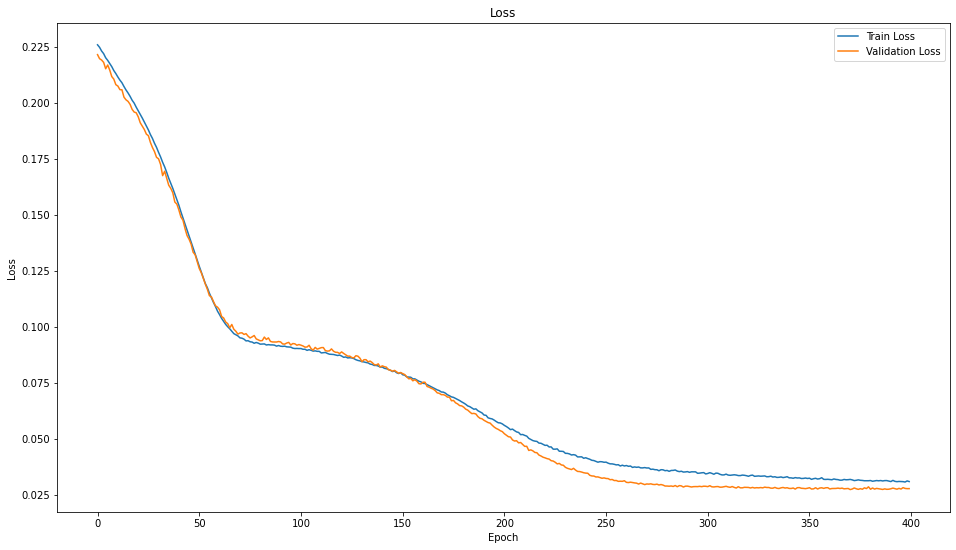

In [29]:
'''
train, validation loss 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(trn_loss_list, label = 'Train Loss')
plt.plot(val_loss_list, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [30]:
'''
평가
'''
original = []
result = []
for i, batch in enumerate(test_dataloader):
    x, y = batch
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    pred = model(x)
    label = y
    loss = criterion(pred, label)
    original.append(y.tolist())
    result.append(pred.tolist())
    
print(len(result))
print(len(original))

test_original_np = np.array(sum(sum(original, []), []))
test_result_np = np.array(sum(sum(result, []), []))

15
15


In [31]:
'''
데이터프레임 reshape
'''
test_original_df = pd.DataFrame(test_original_np.reshape(-1, 3))
test_result_df = pd.DataFrame(test_result_np.reshape(-1, 3))

print(test_original_df.shape)
print(test_result_df.shape)

(3650, 3)
(3650, 3)


In [32]:
'''
결과 데이터 데이터프레임 결합
'''
reshaped_test_original_df = pd.concat([x_test_data_df, test_original_df], axis = 1)
reshaped_test_result_df = pd.concat([x_test_data_df, test_result_df], axis = 1)

In [33]:
'''
예측 데이터 데이터프레임 변환
'''
inversed_test_original_np = max_abs_scaler.inverse_transform(reshaped_test_original_df)
inversed_test_original_df = pd.DataFrame(inversed_test_original_np)

inversed_test_result_np = max_abs_scaler.inverse_transform(reshaped_test_result_df)
inversed_test_result_df = pd.DataFrame(inversed_test_result_np)

In [34]:
'''
데이터프레임 columns 이름 변경
'''
inversed_test_original_df.columns = [['frontyear', 'backyear', 'month', 'day', 'season', 'O_temp_avg', 'O_temp_min', 'O_temp_max']]
inversed_test_result_df.columns = [['frontyear', 'backyear', 'month', 'day', 'season', 'P_temp_avg', 'P_temp_min', 'P_temp_max']]

dropped_test_original_df = inversed_test_original_df[['O_temp_avg', 'O_temp_min', 'O_temp_max']]
dropped_test_result_df = inversed_test_result_df[['P_temp_avg', 'P_temp_min', 'P_temp_max']]

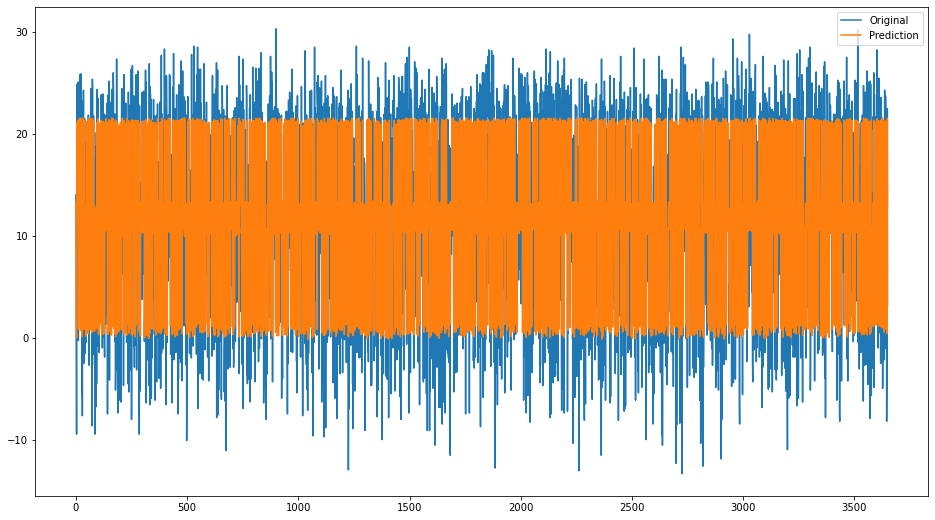

In [35]:
'''
결과 데이터 시각화
'''
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()

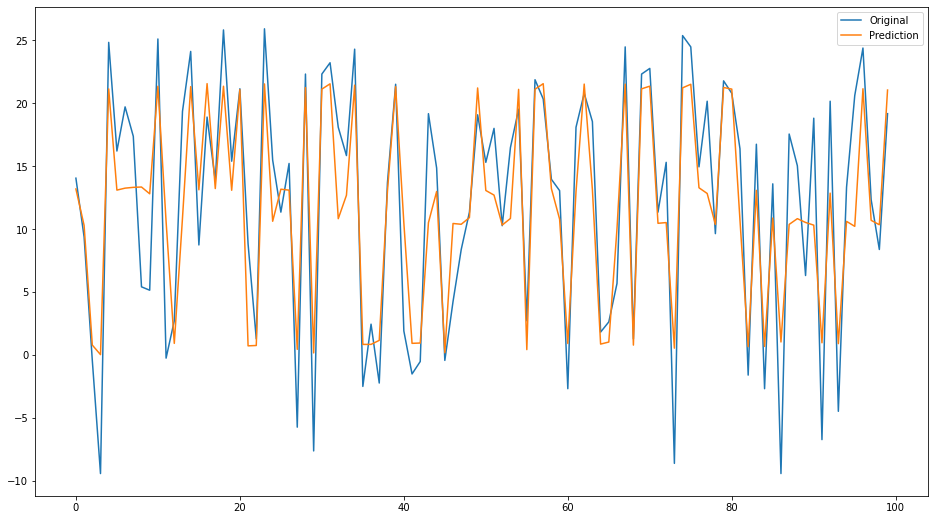

In [36]:
plt.figure(figsize = (16, 9))
plt.plot(dropped_test_original_df[['O_temp_avg']][:100], label = 'Original')
plt.plot(dropped_test_result_df[['P_temp_avg']][:100], label = 'Prediction')
plt.legend(loc = 'upper right')
plt.show()